# 예측모델: ARIMA, Seasonal ARIMA (SARIMA) 실습

![image-2.png](attachment:image-2.png)

![image.png](attachment:image.png)

### 1. 모듈 불러오기

In [ ]:
!pip install pmdarima

In [1]:
#!pip install pandas_datareader

import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
#sns.set_style("white")
%matplotlib inline

import itertools

### 2. 데이터 불러오기

![image-2.png](attachment:image-2.png)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AirPassengers.csv')
data = data.rename(columns={'Month': 'month', '#Passengers': 'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


### 3. Box-Jenkins ARIMA Procedure
-  3.1 Data Preprocessing
-  3.2 Identify Model to be Tentatively Entertainted
-  3.3 Estimate Parameters
-  3.4 Diagnosis Check
-  3.5 use Model to Forecast

#### 3.1 Data Preprocessing

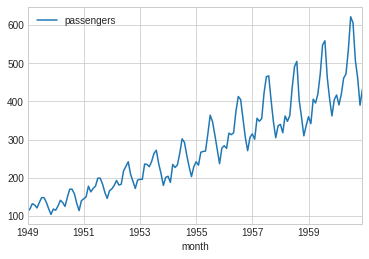

In [5]:
# Raw data plot
fig = data.plot()

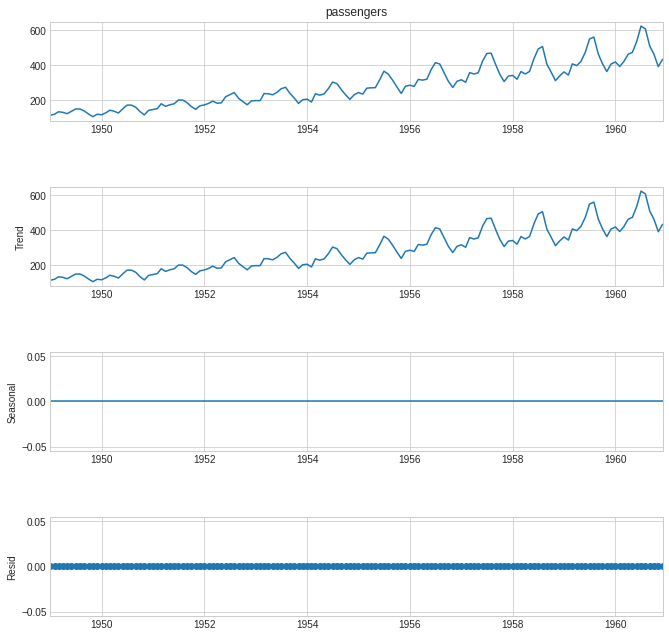

In [6]:
# Seasonal decomposition plot: Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

# Observed: observed data
# Trend: The estimated trend component
# Seasonal: The estimated seasonal component
# resid: The estimated residuals

decompostion = sm.tsa.seasonal_decompose(data['passengers'],  model='additive',  period=1)
fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

#### 3.2 Identify Model to be Tentatively Entertainted

In [7]:
# Train:Test = 8:2
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


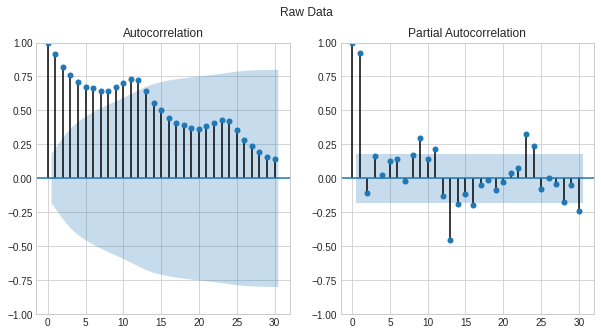

In [8]:
# ACF, PACF plot 

# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

![image.png](attachment:image.png)

In [9]:
# Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna()
print('####### Raw Data #######')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

####### Raw Data #######
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
### Differenced Data ###
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


In [ ]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data,'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

In [ ]:
# ACF, PACF plot 

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]); # Modify not to generate graph twice

![image.png](attachment:image.png)

#### 3.3 Estimate Parameters

In [10]:
# ARIMA model fitting
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.

model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

NotImplementedError: ignored

#### 3.4.1 Diagnosis Check - ARIMA

In [ ]:
# Parameter search 

print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

aic=[]
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

In [ ]:
# Search optimal parameters

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

In [ ]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

#### 3.5.1 use Model to Forecast - ARIMA

In [ ]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

#### 3.4.2 Diagnosis Check - SARIMA

In [ ]:
# Parameter search 

print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic=[]
params=[]
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))  
        except:
            continue

In [ ]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

In [ ]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

#### 3.5.2 use Model to Forecast - SARIMA

In [ ]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 700, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]},{optimal[0][0][1]} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

#### 3.4.3 Diagnosis Check - auto_arima

In [ ]:
# Parameter search 

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1, 
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

In [ ]:
auto_arima_model.summary()

#### 3.5.3 use Model to Forecast - auto_arima

In [ ]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 700, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order},{auto_arima_model.seasonal_order} Prediction Results (r2_score: {round(r2,2)})')
plt.show()

### 4. Case Study: 주가예측

![image.png](attachment:image.png)

In [ ]:
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    code = code.strip()
    return code

In [ ]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_data # 2380 rows × 9 columns

In [ ]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns={'회사명': 'name', '종목코드': 'code'})
code_data.code = code_data.code.map('{:06d}'.format)

In [ ]:
stock_code = get_code(code_data, 'LG이노텍')
stock_code = stock_code + '.KS'
stock_data = pdr.get_data_yahoo(stock_code)

'''
High: 장 중 제일 높았던 주가(고가)
Low: 장 중 제일 낮았던 주가(저가)
Open: 장 시작 때 주가(시가)
Close: 장 닫을 때 주가(종가)
Volume: 주식 거래량
Adj Close: 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

'''

stock_data

In [ ]:
stock_data = stock_data[['Close']]
fig = stock_data.plot()

In [ ]:
from sklearn.model_selection import train_test_split
stock_data_train, stock_data_test = train_test_split(stock_data, test_size=0.05, shuffle=False)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags=40, ax=ax[1]); # Modify not to generate graph twice

In [ ]:
diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train['Close'].diff()
diff_stock_data_train = diff_stock_data_train.dropna()
print('####### Raw Data #######')
print(stock_data_train)
print('### Differenced Data ###')
print(diff_stock_data_train)

In [ ]:
# Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(stock_data_train['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_stock_data_train,'orange') # first difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_stock_data_train.values.squeeze(), lags=40, ax=ax[1]); # Modify not to generate graph twice

In [ ]:
# Parameter search 

auto_arima_model = auto_arima(stock_data_train, start_p=1, start_q=1,
                              max_p=3, max_q=3, seasonal=False,
                              d=1,
                              trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=False)

In [ ]:
auto_arima_model.summary()

In [ ]:
prediction = auto_arima_model.predict(len(stock_data_test), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(stock_data_test.index)
predict_index[0]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
stock_data.plot(ax=ax);
ax.vlines('2020-07-14', 50000, 225000, linestyle='--', color='r', label='Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order},Prediction Results')
plt.show()

# EOD